In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, iirnotch, sosfilt, sosfreqz, lfilter, filtfilt
import biosppy

import tensorflow as tf
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.rcParams["figure.figsize"] = (10,5)

In [2]:
def butter_highpass(cutoff, sample_rate, order, data):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    final_filtered_highpass = filtfilt(b, a, data)
    return final_filtered_highpass


def butter_lowpass(cutoff, sample_rate, order, data, slice=-1):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_lowpass = lfilter(b, a, data)
    return filtered_lowpass


def moving_average_filter(x, w):
    m_a_filtered = np.convolve(x, np.ones(w), 'same') / w
    return m_a_filtered


def filter_data(data, sample_rate=100):
    filtered_data_low = butter_lowpass(41.09, sample_rate, 5, data)
    filtered_data_high = butter_highpass(0.48, sample_rate, 2, filtered_data_low)
    #final_filtered_data = moving_average_filter(filtered_data_high, 3)
    return filtered_data_high

In [3]:
def plot_conf_matrix(y_test, y_pred):
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test,y_pred), cmap='Blues', annot=True, fmt='g');
    plt.title('Confusion Matrix')
    plt.xlabel("Predictions")
    plt.ylabel("Real values")
    plt.show()

In [4]:
df = pd.read_csv("ECG_Rhythm_Lead_I.csv")
del df["Unnamed: 0"]
df.shape

(21837, 1006)

In [5]:
df = df.loc[df.rhythm_diag != 'OTHER']
df['rhythm_diag'] = df['rhythm_diag'].map(dict(AFIB=1, SR=0))
df_minority = df[df['rhythm_diag']==1]
df_majority = df[df['rhythm_diag']==0]
maj_class = resample(df_majority,
                     replace=True,
                     n_samples=1514,
                     random_state=123)
df=pd.concat([df_minority,maj_class])
df.rhythm_diag.value_counts()
df_sr = df[df.rhythm_diag == 0]
df_sr = df_sr.drop(['ecg_id', 'age', 'sex', 'height',
                    'weight', 'rhythm_diag'], axis=1)
df_sr.reset_index(drop= True ,inplace=True)
df_sr.shape
df_afib = df[df.rhythm_diag == 1]
df_afib = df_afib.drop(
    ['ecg_id', 'age', 'sex', 'height', 'weight', 'rhythm_diag'], axis=1)
df_afib.reset_index(drop=True, inplace=True)
df_afib.shape

(1514, 1000)

In [6]:
df.head()

,ecg_id,age,sex,height,weight,rhythm_diag,0,1,2,3,...,990,991,992,993,994,995,996,997,998,999
16,17,56.0,0,NaN,NaN,1,-0.041,-0.025,0.041,0.036,...,-0.074,-0.054,-0.036,-0.027,0.020,0.028,0.055,0.063,0.058,0.079
151,152,70.0,1,NaN,NaN,1,-0.008,-0.029,-0.026,-0.006,...,0.067,0.055,0.037,0.038,0.060,0.084,0.113,0.097,0.076,0.058
281,282,91.0,0,175.0,NaN,1,-0.262,-0.285,-0.293,-0.271,...,-0.160,-0.173,-0.238,-0.268,-0.270,-0.238,-0.204,-0.230,-0.247,-0.214
306,307,63.0,0,174.0,64.0,1,-0.043,-0.056,-0.071,-0.105,...,-0.010,-0.021,-0.013,-0.018,-0.010,-0.014,-0.010,-0.064,-0.128,-0.144
317,318,56.0,0,163.0,94.0,1,-0.199,-0.115,0.145,0.372,...,0.040,0.062,0.082,0.116,0.112,0.115,0.112,0.112,0.074,0.077


In [6]:
df['rhythm_diag'] = df['rhythm_diag'].map(dict(OTHER=2,AFIB=1, SR=0))
df.rhythm_diag.value_counts()

0    16782
2     3541
1     1514
Name: rhythm_diag, dtype: int64

In [7]:
df_minority = df[df['rhythm_diag']==1]
df_majority_SR = df[df['rhythm_diag']==0]
df_majority_OTHER = df[df['rhythm_diag']==2]
maj_class_SR = resample(df_majority_SR,
                         replace=True,
                         n_samples=1514,
                         random_state=123)
maj_class_OTHER = resample(df_majority_OTHER,
                             replace=True,
                             n_samples=1514,
                             random_state=123)
df=pd.concat([df_minority,maj_class_SR,maj_class_OTHER])

In [8]:
df_sr = df[df.rhythm_diag == 0]
df_sr = df_sr.drop(['ecg_id', 'age', 'sex', 'height',
                    'weight', 'rhythm_diag'], axis=1)
df_sr.reset_index(drop= True ,inplace=True)
df_sr.shape

(1514, 1000)

In [9]:
df_afib = df[df.rhythm_diag == 1]
df_afib = df_afib.drop(
    ['ecg_id', 'age', 'sex', 'height', 'weight', 'rhythm_diag'], axis=1)
df_afib.reset_index(drop=True, inplace=True)
df_afib.shape

(1514, 1000)

In [10]:
df_other = df[df.rhythm_diag == 2]
df_other = df_other.drop(
    ['ecg_id', 'age', 'sex', 'height', 'weight', 'rhythm_diag'], axis=1)
df_other.reset_index(drop=True, inplace=True)
df_other.shape

(1514, 1000)

In [11]:
X_sr = df_sr.values
X_afib = df_afib.values
X_other = df_other.values

In [12]:
def maior_valor_sinal(sinal):
    maior_valor = 0
    for i in range(len(sinal)):
        if(sinal[i] > maior_valor):
            maior_valor = sinal[i]
    return maior_valor

In [13]:
def R_peak_detection(sinal):
    sinal = filter_data(sinal,100)
    indice_aux = 0
    indice_maximo = []
    valor_aux = 0
    valor_maximo = []
    flag_contagem = 0
    indice_temp = 0
    valor_temp = 0
    i = 0
    valor_referencia = maior_valor_sinal(sinal)*0.5
    #print(valor_referencia)
    while i < len(sinal):
        if(sinal[i] > (valor_referencia)):
            indice_aux = i;
            valor_aux = sinal[i];
            if((indice_aux + 5) > len(sinal)):
                pass
            else:
                for x in range(5):
                    if(sinal[indice_aux+x] > valor_aux):
                        indice_temp = indice_aux + x
                        valor_temp = sinal[indice_aux + x]
                        valor_aux = sinal[indice_aux+x]
                    else:
                        flag_contagem = flag_contagem + 1
                indice_maximo.append(indice_temp) 
                valor_maximo.append(valor_temp) 
                if(flag_contagem == 5):
                    indice_maximo.append(i) 
                    valor_maximo.append(sinal[i]) 
                flag_contagem = 0
                indice_temp = 0
                valor_temp = 0
                indice_aux = 0
                valor_aux = 0
                #print(indice_temp+i)
                #print(indice_maximo)
                i = i + 30
        i = i + 1
    contador_zeros = 0
    for j in range (len(indice_maximo)):
        if(indice_maximo[j] == 0):
            contador_zeros = contador_zeros + 1
    for k in range (len(indice_maximo) - contador_zeros):
        if(indice_maximo[k] == 0):
            indice_maximo = np.delete(indice_maximo, k)
    return indice_maximo

In [14]:
def Get_Heartbeats(sinal, frequencia_amostragem, plot = True):
    picos_R = R_peak_detection(sinal)
    heartbeats = []
    indice_min = 0
    indice_max = 0
    zero_points_after = 0
    zero_points_before = 0
    zero_points_aux = 0
    zero_points_aux_1 = 0
    zero_points_aux_2 = 0
    hb = []
    tamanho_sinal = len(sinal)
    tamanho_picos = len(picos_R)-1
    for i in range(1,tamanho_picos):
        difference_peaks_before = picos_R[i]-picos_R[i-1]
        difference_peaks_after = picos_R[i+1]-picos_R[i]
        if((difference_peaks_before >= 25) and (difference_peaks_after >= 35)):
            indice_min = picos_R[i] - (0.25*frequencia_amostragem)
            indice_max = picos_R[i] + (0.35*frequencia_amostragem)
            heartbeats.append(sinal[int(indice_min):int(indice_max)])
        elif((difference_peaks_before) >= 25 and (difference_peaks_after < 35)):
            zero_points_after = 35 - int(difference_peaks_after/2)
            zero_points_aux = np.zeros(zero_points_after)
            indice_min = picos_R[i] - (0.25*frequencia_amostragem)
            indice_max = picos_R[i] + int(difference_peaks_after/2)
            heartbeats.append(np.concatenate((sinal[int(indice_min):int(indice_max)],zero_points_aux), axis=None))
        elif((difference_peaks_before < 25) and (difference_peaks_after >= 35)):
            zero_points_before = 25 - int(difference_peaks_before/2)
            zero_points_aux = np.zeros(zero_points_before)
            indice_min = picos_R[i] - int(difference_peaks_before/2)
            indice_max = picos_R[i] + (0.35*frequencia_amostragem) 
            heartbeats.append(np.concatenate((zero_points_aux, sinal[int(indice_min):int(indice_max)]), axis=None))
        elif((difference_peaks_before < 25) and (difference_peaks_after < 35)):
            zero_points_before = 25 - int(difference_peaks_before/2)
            zero_points_after = 35 - int(difference_peaks_after/2)
            zero_points_aux_1 = np.zeros(zero_points_before)
            zero_points_aux_2 = np.zeros(zero_points_after)
            indice_min = picos_R[i] - int(difference_peaks_before/2)
            indice_max = picos_R[i] + int(difference_peaks_after/2)
            heartbeats.append(np.concatenate((zero_points_aux_1, sinal[int(indice_min):int(indice_max)], zero_points_aux_2), axis=None))
    heartbeats = np.array(heartbeats)
    #print(heartbeats.shape)
    if plot:
        for j in range(len(heartbeats)):
            plt.plot(heartbeats[j])
    return heartbeats

In [15]:
def Get_Complete_Heartbeats(sinal, frequencia_amostragem, plot = True):
    templates = []
    templates_aux = []
    hb = []
    hb_aux = []
    for i in range(len(sinal)): 
        hb_aux = Get_Heartbeats(sinal[i], 100, False)
        for j in range(len(hb_aux)):
            hb.append(hb_aux[j])
    return np.array(hb)

In [16]:
X_sr = Get_Complete_Heartbeats(X_sr, 100, plot = False)
X_sr.shape

(14965, 100)

In [17]:
y_sr = []
y_sr_content = [0,1,0]
for i in range(len(X_sr)):
    y_sr.append(y_sr_content)
y_sr = np.array(y_sr)
y_sr.shape

(14965, 3)

In [18]:
X_afib = Get_Complete_Heartbeats(X_afib, 100, plot = False)
X_afib.shape

(18567, 100)

In [19]:
y_afib = []
y_afib_content = [0,0,1]
for i in range(len(X_afib)):
    y_afib.append(y_afib_content)
y_afib = np.array(y_afib)
y_afib.shape

(18567, 3)

In [20]:
X_other = Get_Complete_Heartbeats(X_other, 100, plot = False)
X_other.shape

(16186, 100)

In [21]:
y_other = []
y_other_content = [1,0,0]
for i in range(len(X_other)):
    y_other.append(y_other_content)
y_other = np.array(y_other)
y_other.shape

(16186, 3)

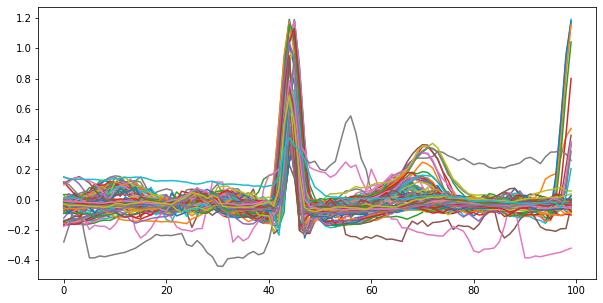

In [23]:
for i in range(100):
    plt.plot(X_other[i])

In [26]:
X_other = X_other[0:50]

In [27]:
X_other.shape

(50, 100)

In [30]:
from numpy import savetxt

for i in range(len(X_other)):
    savetxt('../data/heart_beat_out_data/other/afib_' +
            str(i)+'.csv', X_other[i], delimiter=',')

In [31]:
for i in range(len(X_other)):
    filename_in = "../data/heart_beat_out_data/other/afib_"+str(i)+".csv"
    filename_out = "../data/heart_beat_out_data/other_out/afib.afib_"+str(i)+".csv"
    df_sr = pd.read_csv(filename_in, names=['ecg'])
    df_sr.reset_index(inplace=True)
    savetxt(filename_out, df_sr, delimiter=',',
            header="timestamp, ecg", comments='')